<a href="https://colab.research.google.com/github/spdin/cnn-fashion-mnist/blob/master/Fashion_MNIST_VGG_%26_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST - VGG & ResNet

# Import Library


In [12]:
import os
import torch
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch import optim
from torchvision import models
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torch.utils.model_zoo import load_url as load_state_dict_from_url

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


# Plot Data

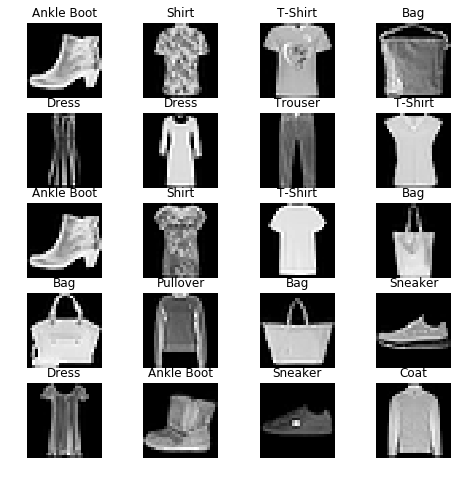

In [4]:
transform = transforms.ToTensor()
                                
trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=0)


labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

fig = plt.figure(figsize=(8,8));

columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(trainset));
    img = trainset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[trainset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
plt.show()

# Data Loader

In [0]:
batchSize = 64
nworkers = 4

transform = transforms.Compose([transforms.Resize(96),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.Grayscale(3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

transform_test = transforms.Compose([transforms.Resize(96),
                                     transforms.Grayscale(3),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=nworkers)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=nworkers)

# CNN

### VGG

In [0]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)


def vgg11_bn(pretrained=False, progress=True, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)


def vgg13(pretrained=False, progress=True, **kwargs):
    """VGG 13-layer model (configuration "B")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)


def vgg13_bn(pretrained=False, progress=True, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)


def vgg16(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)


def vgg16_bn(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained=False, progress=True, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)


def vgg19_bn(pretrained=False, progress=True, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

### ResNet

In [0]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-50 32x4d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-101 32x8d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    """Constructs a Wide ResNet-50-2 model.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    """Constructs a Wide ResNet-101-2 model.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

# Training function

In [0]:
def run_model(net, loader, criterion, optimizer, train = True):
    running_loss = 0
    running_accuracy = 0

    # Set mode
    if train:
        net.train()
    else:
        net.eval()

    for i, (X, y) in enumerate(loader):
        # Pass to gpu or cpu
        X, y = X.to(device), y.to(device)
        

        # Zero the gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(train):
          
            output = net(X)
            
            _, pred = torch.max(output, 1)
            
            loss = criterion(output, y)

        # If on train backpropagate
        if train:
            loss.backward()
            optimizer.step()
            
        # Calculate stats
        running_loss += loss.item()
        running_accuracy += torch.sum(pred == y.detach())
        
    return running_loss / len(loader), running_accuracy.double() / len(loader.dataset)


def run_training(net, criterion, optimizer, start_epoch, nepochs):
  
  #nepochs = 10
  #learning_rate = 0.005
  
  time_total = 0
  
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
  
  # get class name in string
  model_str = net.__class__.__name__

  dirName = model_str
  try:
    # Create target Directory
    os.mkdir(dirName)
  except FileExistsError:
    print("")

  for e in range(start_epoch, nepochs + 1):
    start = time.time()
    
    scheduler.step()

    train_loss, train_acc = run_model(net, trainloader, criterion, optimizer)

    val_loss, val_acc = run_model(net, testloader, criterion, optimizer, False)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    end = time.time()
    
    time_process = end - start
    
    time_total = time_total + time_process

    # print stats
    stats = """Epoch: {}\t 
          train loss: {:.8f}, train acc: {:.8f}\t
          val loss: {:.8f}, val acc: {:.8f}\t
          time: {:.1f}s Total time: {:.1f}s""".format(e, train_loss, train_acc, val_loss, val_acc, time_process, time_total)
    
    print(stats)
    
    # save weight per epoch
    PATH = './' + model_str + '/'+ model_str +'_' + str(e) + '.pth'
    
    PATH_data = './' + model_str + '/'+ model_str + '_data_' + str(e) + '.pth'
    
    torch.save({
            'epoch': e,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc}, PATH)
    
    torch.save({
            'epoch': e,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc}, PATH_data)
    
  nepoch_list = list(range(1, len(train_loss_list)+1))

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Losses')
  plt.ylabel('Losses')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_loss_list,label = "Train losses")
  plt.plot(nepoch_list, val_loss_list, label = "Test losses")
  plt.legend()

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Accuracy')
  plt.ylabel('Accuracy')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_acc_list, label = "Train accuracy")
  plt.plot(nepoch_list, val_acc_list, label = "Test accuracy")
  plt.legend()

 

# Training Process

## VGG-16

Epoch: 1	 
          train loss: 2.63754537, train acc: 0.10173333	
          val loss: 2.32758362, val acc: 0.10000000	
          time: 198.9s Total time: 198.9s
Epoch: 2	 
          train loss: 2.31478340, train acc: 0.11226667	
          val loss: 1.74216241, val acc: 0.24800000	
          time: 203.8s Total time: 402.7s
Epoch: 3	 
          train loss: 1.20528483, train acc: 0.54465000	
          val loss: 0.52163810, val acc: 0.80830000	
          time: 205.7s Total time: 608.4s
Epoch: 4	 
          train loss: 0.45752114, train acc: 0.83088333	
          val loss: 0.42287260, val acc: 0.84070000	
          time: 207.1s Total time: 815.5s
Epoch: 5	 
          train loss: 0.37626352, train acc: 0.85971667	
          val loss: 0.35096779, val acc: 0.86320000	
          time: 207.3s Total time: 1022.9s
Epoch: 6	 
          train loss: 0.33442255, train acc: 0.87460000	
          val loss: 0.31332550, val acc: 0.88210000	
          time: 207.5s Total time: 1230.3s
Epoch: 7	 
         

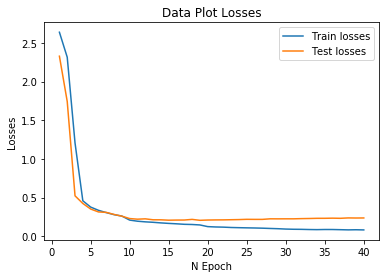

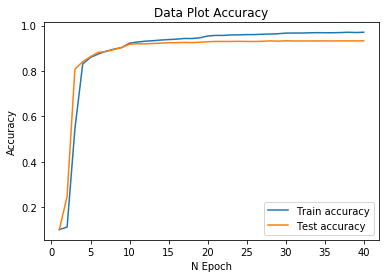

In [25]:
net = vgg16().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

## ResNet 18

In [21]:
net = resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

start_epoch = 1
nepochs = 50

run_training(net, criterion, optimizer, start_epoch, nepochs)


Epoch: 1	 
          train loss: 0.48645464, train acc: 0.82921667	
          val loss: 0.36950034, val acc: 0.86340000	
          time: 60.0s Total time: 60.0s
Epoch: 2	 
          train loss: 0.28859879, train acc: 0.89456667	
          val loss: 0.26224807, val acc: 0.90640000	
          time: 59.5s Total time: 119.5s
Epoch: 3	 
          train loss: 0.24169002, train acc: 0.91080000	
          val loss: 0.24014354, val acc: 0.91200000	
          time: 59.6s Total time: 179.1s
Epoch: 4	 
          train loss: 0.22005686, train acc: 0.91840000	
          val loss: 0.23601872, val acc: 0.91340000	
          time: 59.5s Total time: 238.6s
Epoch: 5	 
          train loss: 0.19649020, train acc: 0.92745000	
          val loss: 0.21511839, val acc: 0.92200000	
          time: 59.5s Total time: 298.1s
Epoch: 6	 
          train loss: 0.18340453, train acc: 0.93210000	
          val loss: 0.23847325, val acc: 0.91370000	
          time: 59.6s Total time: 357.7s
Epoch: 7	 
          train l

KeyboardInterrupt: ignored

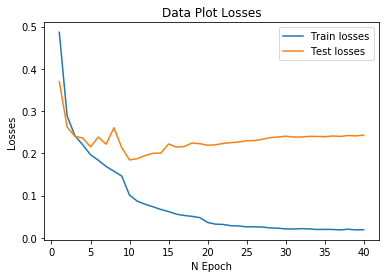

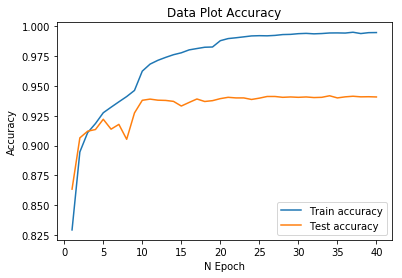

In [28]:
import matplotlib.ticker as mticker

def plot_based_model(n):
  # save weight per epoch
  
  model_str_f = 'ResNet18'
  model_str = 'ResNet'
  
  train_loss_list = []
  val_loss_list = []
  train_acc_list = []
  val_acc_list = []
  
  for e in range(1, n + 1):
    
    PATH = './' + model_str_f + '/'+ model_str +'_data_' + str(e) + '.pth'
    
    checkpoint = torch.load(PATH)

    train_loss_list.append(checkpoint['train_loss'])
    val_loss_list.append(checkpoint['val_loss'])
    train_acc_list.append(checkpoint['train_acc'])
    val_acc_list.append(checkpoint['val_acc'])
  
  nepoch_list = list(range(1, len(train_loss_list)+1))

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Losses')
  plt.ylabel('Losses')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_loss_list,label = "Train losses")
  plt.plot(nepoch_list, val_loss_list, label = "Test losses")
  plt.legend()

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Accuracy')
  plt.ylabel('Accuracy')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_acc_list, label = "Train accuracy")
  plt.plot(nepoch_list, val_acc_list, label = "Test accuracy")
  plt.legend()


plot_based_model(40)



Epoch: 1	 
          train loss: 0.88178903, train acc: 0.73768333	
          val loss: 0.80629986, val acc: 0.81350000	
          time: 160.5s Total time: 160.5s
Epoch: 2	 
          train loss: 0.39553952, train acc: 0.85588333	
          val loss: 0.39591382, val acc: 0.86030000	
          time: 160.6s Total time: 321.2s
Epoch: 3	 
          train loss: 0.32441320, train acc: 0.88065000	
          val loss: 0.32900315, val acc: 0.87830000	
          time: 160.5s Total time: 481.7s
Epoch: 4	 
          train loss: 0.28401825, train acc: 0.89426667	
          val loss: 0.29173158, val acc: 0.89700000	
          time: 160.9s Total time: 642.6s
Epoch: 5	 
          train loss: 0.25816575, train acc: 0.90548333	
          val loss: 0.33378676, val acc: 0.90190000	
          time: 160.7s Total time: 803.4s
Epoch: 6	 
          train loss: 0.23552963, train acc: 0.91350000	
          val loss: 0.76847749, val acc: 0.85850000	
          time: 160.6s Total time: 964.0s
Epoch: 7	 
          t

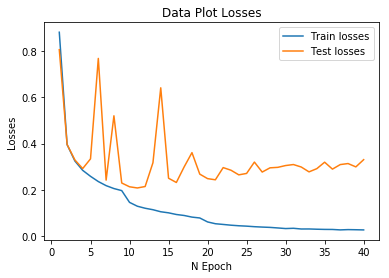

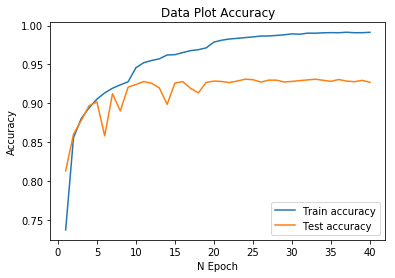

In [23]:
net = resnet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

In [0]:
!mv ResNet ResNet50

In [29]:
net = resnet152().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

Epoch: 1	 
          train loss: 0.86623937, train acc: 0.72506667	
          val loss: 0.56687960, val acc: 0.82840000	
          time: 349.9s Total time: 349.9s
Epoch: 2	 
          train loss: 0.43489970, train acc: 0.83951667	
          val loss: 0.47255554, val acc: 0.85730000	
          time: 357.0s Total time: 706.9s
Epoch: 3	 
          train loss: 0.37135576, train acc: 0.86311667	
          val loss: 0.35419848, val acc: 0.87340000	
          time: 357.2s Total time: 1064.1s
Epoch: 4	 
          train loss: 0.33541114, train acc: 0.87463333	
          val loss: 0.35135882, val acc: 0.87840000	
          time: 357.2s Total time: 1421.2s
Epoch: 5	 
          train loss: 0.31115460, train acc: 0.88288333	
          val loss: 0.37869231, val acc: 0.88770000	
          time: 357.1s Total time: 1778.3s
Epoch: 6	 
          train loss: 0.29114005, train acc: 0.89038333	
          val loss: 0.44156655, val acc: 0.88320000	
          time: 357.4s Total time: 2135.7s
Epoch: 7	 
       

KeyboardInterrupt: ignored